# Importing Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    PolynomialFeatures, 
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    KBinsDiscretizer
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge, 
    Lasso,
    ElasticNet
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier
)   
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    recall_score,
    precision_score
)


from scripts.clean_dataset import clean_dataset
from scripts.helper import currency, cal_accuracy


# Importing the cleaned dataset

In [29]:
df_train = pd.read_csv('data/Train_cleaned.csv')
#df_train = pd.read_csv('data/Train_cleaned_log_transformed.csv')

In [30]:
df_train.shape

(3954, 27)

## Categorization of total_cost (using KBins)

In [31]:
kbins = KBinsDiscretizer(
    n_bins=5,
    encode='onehot-dense', # onehot, onehoe-dense, ordinal
    strategy='quantile',   # kmeans, uniform, quantile
)
bin_data  = kbins.fit_transform(df_train[['total_cost_euro']])
bin_names = ['very low', 'low', 'medium', 'high', 'very high']
bin_edges = kbins.bin_edges_[0].round()

# Apply pd.cut with custom bin edges to start the first bin at zero
bin_edges = np.concatenate(([0], bin_edges[1:]))

df_train['total_cost_category'] = pd.cut(
    df_train['total_cost_euro'], 
    bins=bin_edges, 
    labels=bin_names, 
    include_lowest=True,
    right=False
)

### Class-Balance

In [9]:
df_train['total_cost_category'].value_counts(normalize=True)

total_cost_category
very low     0.203844
medium       0.202833
high         0.201821
very high    0.200051
low          0.191452
Name: proportion, dtype: float64

In [32]:
# show the bins
for i in range(len(bin_names)):
    print(bin_names[i].ljust(11), currency(bin_edges[i]).rjust(11), " - ", currency(bin_edges[i+1]).rjust(11))

very low         0.00 €  -     242.00 €
low            242.00 €  -     907.00 €
medium         907.00 €  -   2,238.00 €
high         2,238.00 €  -   5,196.00 €
very high    5,196.00 €  -  36,330.00 €


# Target and Features

In [33]:
# Target:
y = df_train['total_cost_category']
#y = df_train['total_cost']
# Features:
X = df_train.drop([
    'total_cost', 'total_cost_euro', 'total_cost_category', 
], axis=1)

## Seperate numerical and categorical features

In [34]:
num_features = list(X.select_dtypes(include=['number']).columns)
cat_features = list(X.select_dtypes(exclude=['number']).columns)

In [35]:
cat_features = list(set(cat_features) - set(['info_source', 'payment_mode', 'most_impressing', 'single_male', 'single_female']))
num_features = ['total_travelers', 'night_total', 'total_female']

In [36]:
cat_features, num_features

(['travel_with',
  'package_transport_tz',
  'package_accomodation',
  'tour_arrangement',
  'package_transport_int',
  'first_trip_tz',
  'country',
  'age_group',
  'package_sightseeing',
  'purpose',
  'package_insurance',
  'main_activity',
  'package_food',
  'package_guided_tour'],
 ['total_travelers', 'night_total', 'total_female'])

# Splitting the dataset

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)#, stratify=y)#, random_state=47)

# Baseline Model

Our baseline model is just using the median of all spendings.

In [38]:
print('Mean:  ', currency(df_train.total_cost_euro.mean()))
print('Median:', currency(df_train.total_cost_euro.median()))

Mean:   3,209.54 €
Median: 1,482.22 €


In [15]:
df_train.total_cost_euro.describe().apply(lambda x: currency(x))

count     3,954.00 €
mean      3,209.54 €
std       4,580.58 €
min          17.88 €
25%         362.99 €
50%       1,482.22 €
75%       3,932.42 €
max      36,329.50 €
Name: total_cost_euro, dtype: object

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BaselineClassifier(BaseEstimator, ClassifierMixin):
    """
    Baseline model predicting only the majority class 
    in a binary classification problem
    """
    def fit(self, X, y):
        self.majority_ = y.mode()
        return self
    
    def predict(self, X):
        return np.array(X.shape[0]*[self.majority_])

In [40]:
# build baseline model
baseline_model = BaselineClassifier()
baseline_model.fit(X_train, y_train)
baseline_model.score(X_train, y_train)

0.2059992771955186

# Create a pipeline

## Building the pipeline

In [74]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',  StandardScaler()),
#    ('poly',    PolynomialFeatures(degree=10))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

# Create a Logistic Regression pipeline
estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
#   ('classifier',   LogisticRegression(max_iter=10_000, class_weight="balanced"))
    ('classifier',   RandomForestClassifier(max_depth=10, n_estimators=50, min_samples_split=2))
#    ('classifier',   RandomForestRegressor())
#    ('classifier', Ridge(alpha=0.5)),
#    ('classifier', DecisionTreeClassifier(min_samples_leaf=))
#    ('classifier', GradientBoostingClassifier(n_estimators=100))
])

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_travelers',
                                                   'night_total',
                                                   'total_female']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['travel_with',
                                                   'package_transport_tz',
                                                   'package_accomodation',
                                                   'tour_arrangement',
                                                   'package_transport_int',
                                                   'first_trip_tz', 'country',
                                                   'age_group',
                                                   'package_sightseeing',
                                                   'purpose',
                                                   'package_insurance',
                                                   'main_activity',
                                                   'package_food',
                                                   'package_guided_tour'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=50))])

## Predicting

In [75]:
# Predict for training and test sets
y_pred_train = estimator.predict(X_train)
y_pred_test  = estimator.predict(X_test)

## Evaluation

### Training set evaluation

Accuracy on train set: 0.7
Accuracy on train set: 0.7
              precision    recall  f1-score   support

        high       0.74      0.66      0.70       553
         low       0.68      0.52      0.59       522
      medium       0.63      0.62      0.63       554
   very high       0.71      0.87      0.78       570
    very low       0.72      0.79      0.75       568

    accuracy                           0.70      2767
   macro avg       0.70      0.69      0.69      2767
weighted avg       0.70      0.70      0.69      2767



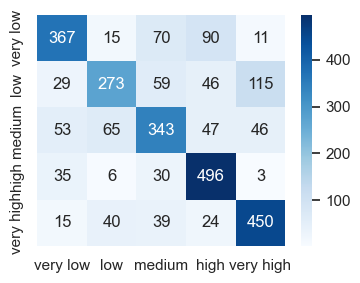

In [76]:
print("Accuracy on train set:", round(estimator.score(X_train, y_train), 2))
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))

print(classification_report(y_train, y_pred_train))

cf_train = confusion_matrix(y_train, y_pred_train)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_train, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

### Test set evaluation

Accuracy on test set: 0.51
Accuracy on test set: 0.51
              precision    recall  f1-score   support

        high       0.49      0.36      0.41       245
         low       0.44      0.29      0.35       235
      medium       0.42      0.45      0.44       248
   very high       0.57      0.76      0.65       221
    very low       0.58      0.71      0.64       238

    accuracy                           0.51      1187
   macro avg       0.50      0.51      0.50      1187
weighted avg       0.50      0.51      0.49      1187



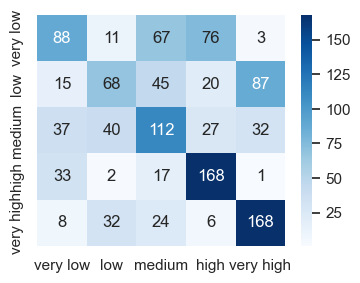

In [77]:
print("Accuracy on test set:", round(estimator.score(X_test,  y_test), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))

print(classification_report(y_test, y_pred_test))

cf_test = confusion_matrix(y_test, y_pred_test)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_test, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

In [22]:
# The evaluation metric for this competition is Mean Absolute Error.

#mean_absolute_error(y_train, y_pred_train)

## Cross Validation

In [23]:
y_pred_test_cv = cross_val_predict(estimator, X_test, y_test, cv=4)

In [24]:
cv_score = estimator.score(X_test, y_pred_test_cv)
print("Cross validation scores:", round(cv_score, 2))
print(classification_report(y_test, y_pred_test_cv))

Cross validation scores: 0.75
              precision    recall  f1-score   support

        high       0.48      0.41      0.44       229
         low       0.36      0.15      0.21       235
      medium       0.47      0.48      0.48       258
   very high       0.57      0.75      0.65       218
    very low       0.54      0.74      0.62       247

    accuracy                           0.51      1187
   macro avg       0.48      0.51      0.48      1187
weighted avg       0.48      0.51      0.48      1187



# Logistic Regression

In [48]:
estimator2 = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('classifier',   LogisticRegression(max_iter=10_000, class_weight="balanced"))
])

estimator2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_travelers',
                                                   'night_total',
                                                   'total_female']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['travel_with',
                                                   'package_transport_tz',
                                                   'package_accomodation',
                                                   'tour_arrangement',
                                                   'package_transport_int',
                                                   'first_trip_tz', 'country',
                                                   'age_group',
                                                   'package_sightseeing',
                                                   'purpose',
                                                   'package_insurance',
                                                   'main_activity',
                                                   'package_food',
                                                   'package_guided_tour'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000))])

In [24]:
# Predict for training and test sets
y_pred_train = estimator.predict(X_train)
y_pred_test  = estimator.predict(X_test)

In [25]:
print("Accuracy on train set:", round(estimator.score(X_train, y_train), 2))
print("Accuracy on train set:", round(estimator.score(X_test, y_test), 2))

Accuracy on train set: 0.57
Accuracy on train set: 0.48


# Grid Search

In [ ]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'classifier': [
#        DecisionTreeClassifier(),
        RandomForestClassifier(max_depth=7, n_estimators=70, min_samples_split=10),
#        GradientBoostingClassifier(),
    ],
    'classifier__n_estimators': [10, 30, 50, 70, 100, 150],
    'classifier__min_samples_split': [2,4,7,10],
    'classifier__min_samples_leaf': [1,2,3,4],
    'classifier__max_depth': [2,4,6,8,10],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
}

# Create GridSearchCV,
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, verbose=1) # scoring='neg_mean_squared_error', #'r2', 

# Fit the model
%timeit grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [53]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_travelers',
                                                   'night_total',
                                                   'total_female']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['travel_with',
                                                   'package_transport_tz',
                                                   'package_accomodation',
                                                   'tour_arrangement',
                                                   'package_transport_int',
                                                   'first_trip_tz', 'country',
                                                   'age_group',
                                                   'package_sightseeing',
                                                   'purpose',
                                                   'package_insurance',
                                                   'main_activity',
                                                   'package_food',
                                                   'package_guided_tour'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=10,
                                        n_estimators=70))])

In [54]:
best_params

{'classifier': RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=70),
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10,
 'preprocessor__num__scaler': StandardScaler()}

In [78]:
print("Train score: ", best_model.score(X_train, y_train))
print("Test score:  ", best_model.score(X_test, y_test))

Train score:  0.6353451391398627
Test score:   0.5214827295703454


# Saving the model

In [79]:
from scripts.model_serializer import ModelSerializer

ModelSerializer('models/best_model.sav').dump(best_model)

# The unused rest

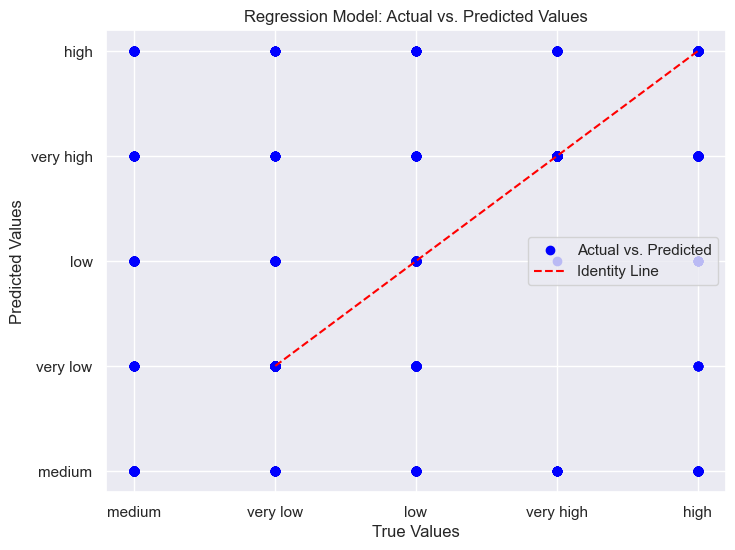

In [55]:

# Plotting the results
plt.figure(figsize=(8, 6))

# Scatter plot of true vs. predicted values
plt.scatter(y_test, y_pred_test, color='blue', label='Actual vs. Predicted')

# Plot the identity line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Identity Line')

plt.title('Regression Model: Actual vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()